In [1]:
import jax

jax.config.update("jax_platform_name", "cpu")

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import skimage
from jax import Array

import chromatix.functional as cf

%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

In [2]:
def show_amplitude_and_phase(amplitude: np.ndarray, phase: np.ndarray):
    fig, axes = plt.subplots(nrows=1, ncols=2, dpi=300)
    ax = axes[0]
    ax.imshow(amplitude, cmap="gray")
    ax.axis("off")
    ax.set_title("amplitude")
    ax = axes[1]
    ax.imshow(phase, cmap="hsv")
    ax.axis("off")
    ax.set_title("phase")

In [3]:
def show_image(image: np.ndarray):
    fig = plt.figure(dpi=150)
    ax = fig.gca()
    ax.imshow(image, cmap="gray")
    plt.colorbar(ax.images[0], ax=ax, orientation="vertical")
    ax.axis("off")
    ax.set_title("image")

In [4]:
def plot_losses(losses: np.ndarray, num_iterations: int):
    fig = plt.figure(dpi=150)
    ax = fig.gca()
    ax.plot(np.mean(np.array(np.array_split(losses, num_iterations)), axis=1))
    ax.set_title("optimization")
    ax.set_ylabel("loss")
    ax.set_xlabel("iteration")

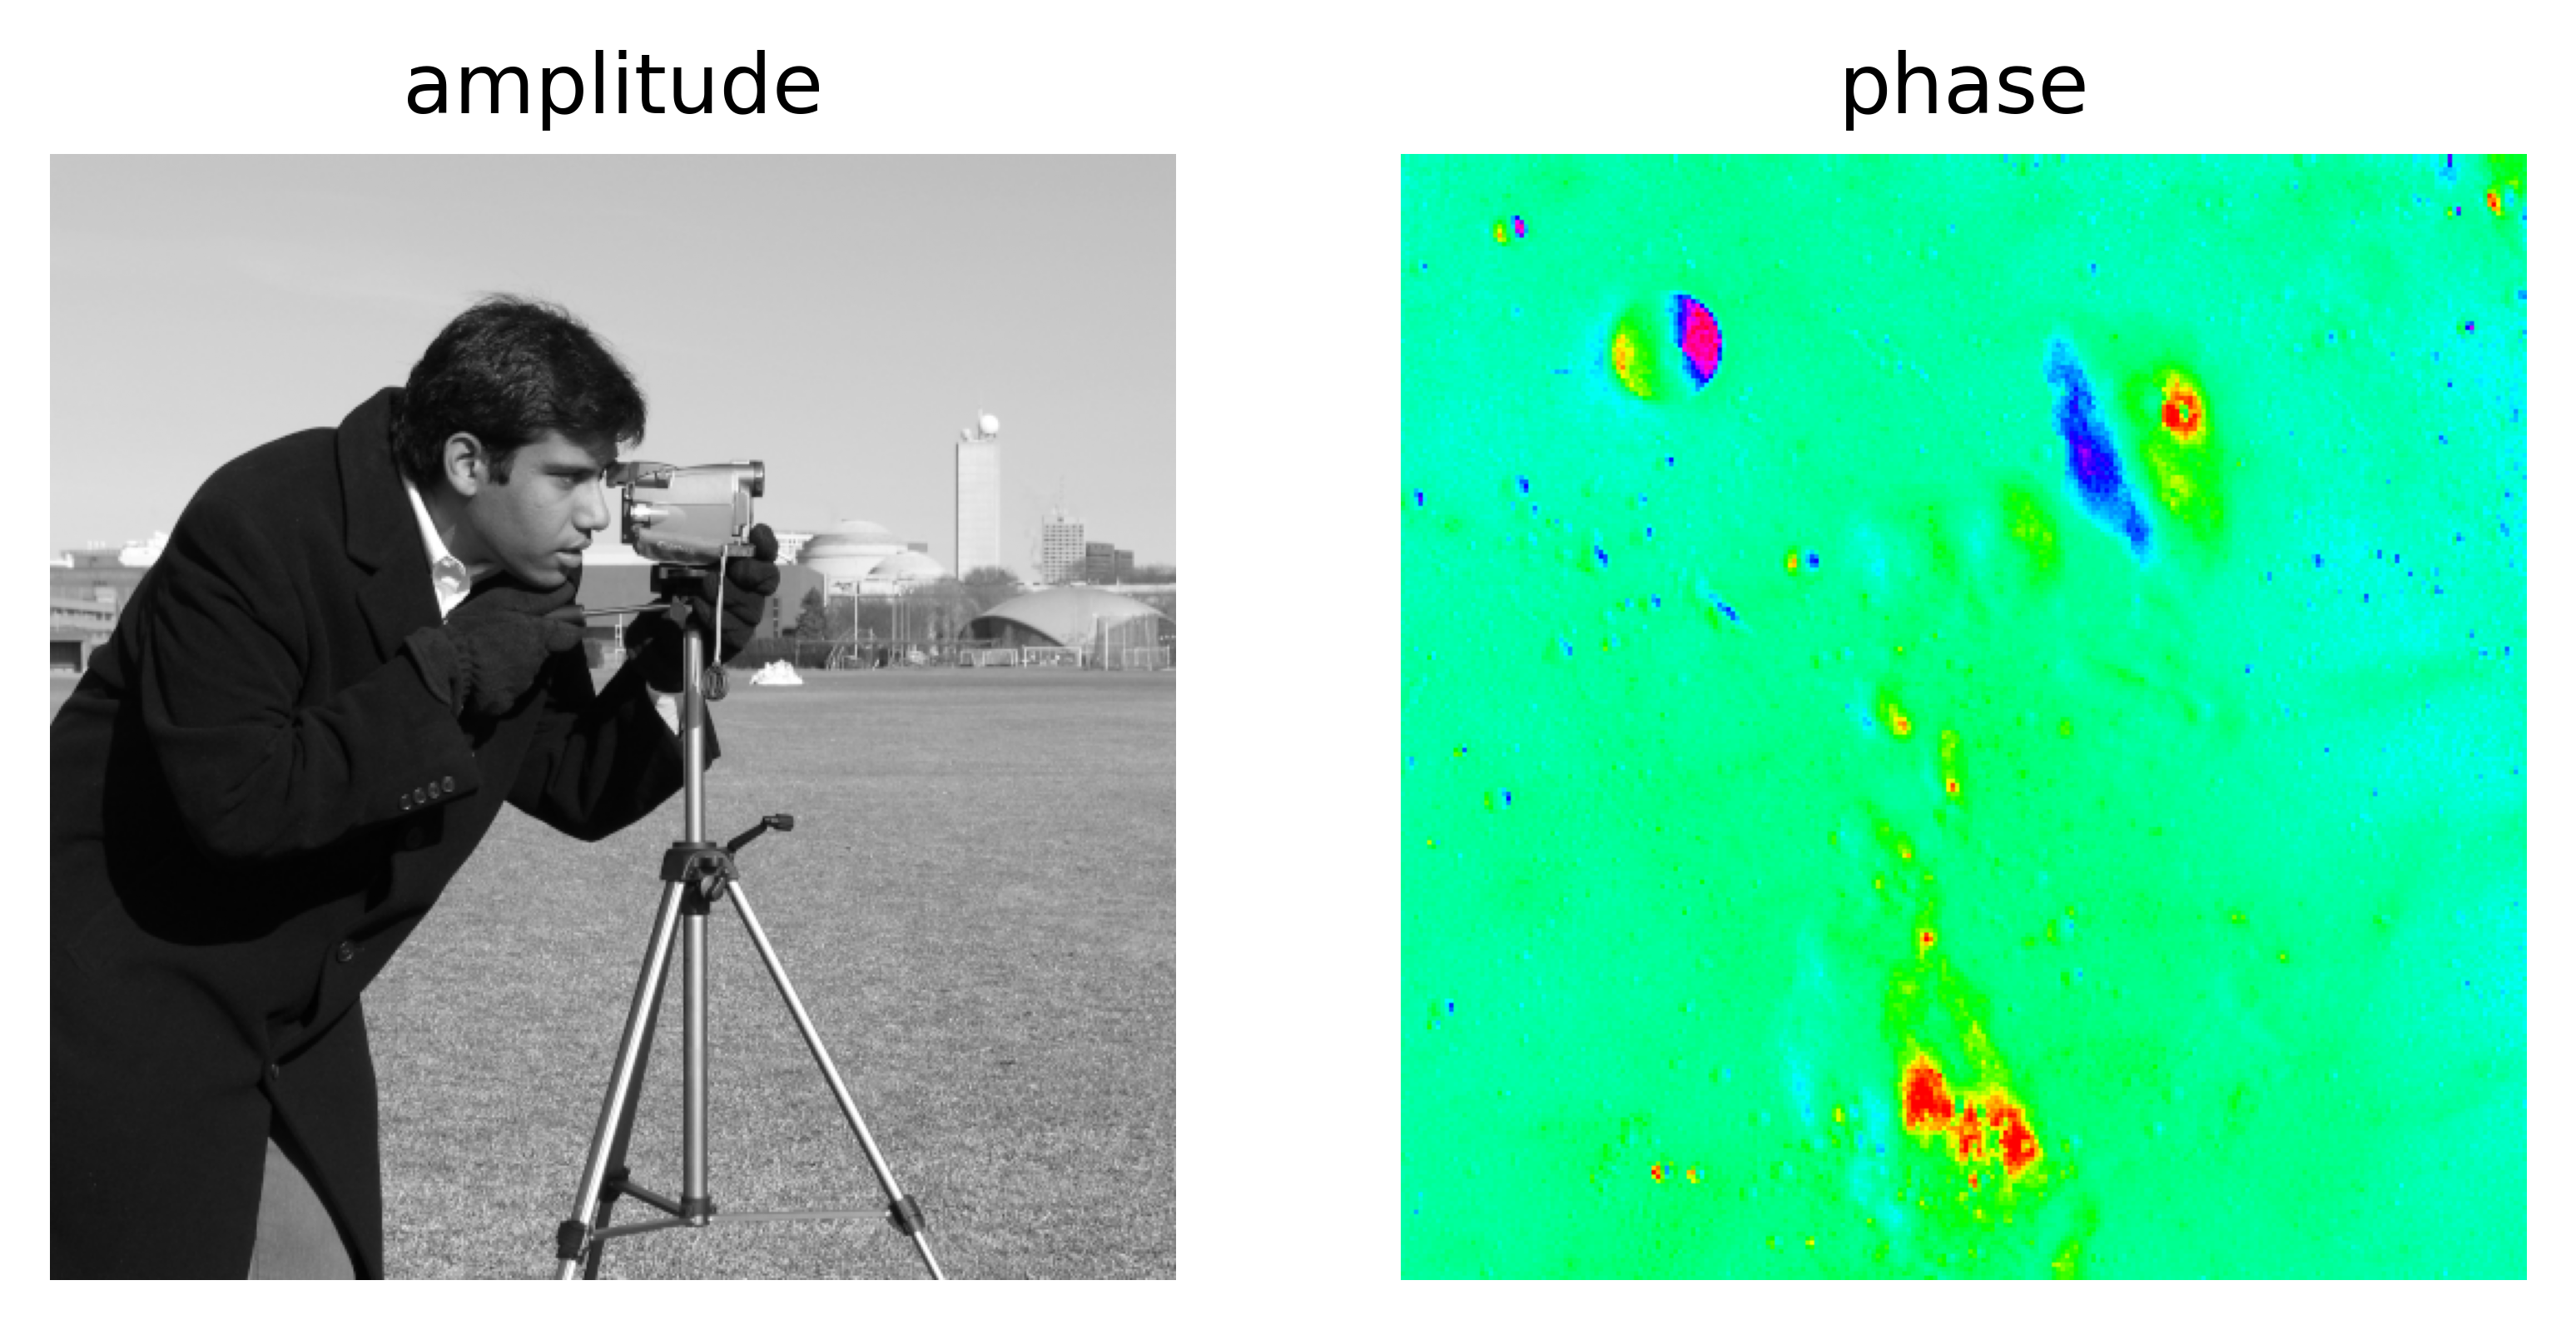

In [5]:
amplitude = skimage.data.camera().astype("float")
amplitude = amplitude / amplitude.max()
phase = skimage.data.moon().astype("float")
phase = np.pi * phase / phase.max()
show_amplitude_and_phase(amplitude, phase)

In [6]:
def imaging_system(amplitude: Array, phase: Array) -> Array:
    # 1. Start with an angled plane wave for illumination.
    # The angle is defined by a shift in Fourier (k) space, given by the kykx vector.
    # You will want to create a field with the same shape as the sample (512, 512) with
    # a pixel spacing (sampling) of 0.3 microns, and a single wavelength of
    field = cf.plane_wave(amplitude.shape, 0.3, 0.532, 1.0)
    # 2. Apply the amplitude of the sample to the incoming illumination field.
    field = cf.amplitude_change(field, amplitude)
    # 3. Apply the phase of the sample to the incoming field.
    field = cf.phase_change(field, phase)
    # 4. Define a 4f system to relay the illuminated sample to the camera plane!
    # You will want to use the same focal length for both lenses in this demo (1.8e3 microns),
    # with a refractive index of 1.33 and an NA in the pupil plane of 0.3.
    # field = cf.ff_lens(field, 10e3, 1.33)
    # field = cf.ff_lens(field, 10e3, 1.33)
    # 5. Return the intensity of the field at the camera plane, since we measure intensity.

    # Same but with high_na_ff_lens()
    field = cf.high_na_ff_lens(field, 10e3, 1.33, NA=1.1)
    field = cf.high_na_ff_lens(field, 10e3, 1.33, NA=1.1)

    # field = cf.ff_lens(field, 50e3, 1.33)
    return field.u

In [7]:
image = jnp.abs(imaging_system(jnp.array(amplitude), jnp.array(phase))) ** 2

1
[0.24181817 0.24181817]
sin_theta2 (1, 512, 512, 1, 1)
field grid (2, 1, 512, 512, 1, 1)
1
[0.24181817 0.24181817]
sin_theta2 (1, 512, 512, 1, 1)
field grid (2, 1, 512, 512, 1, 1)


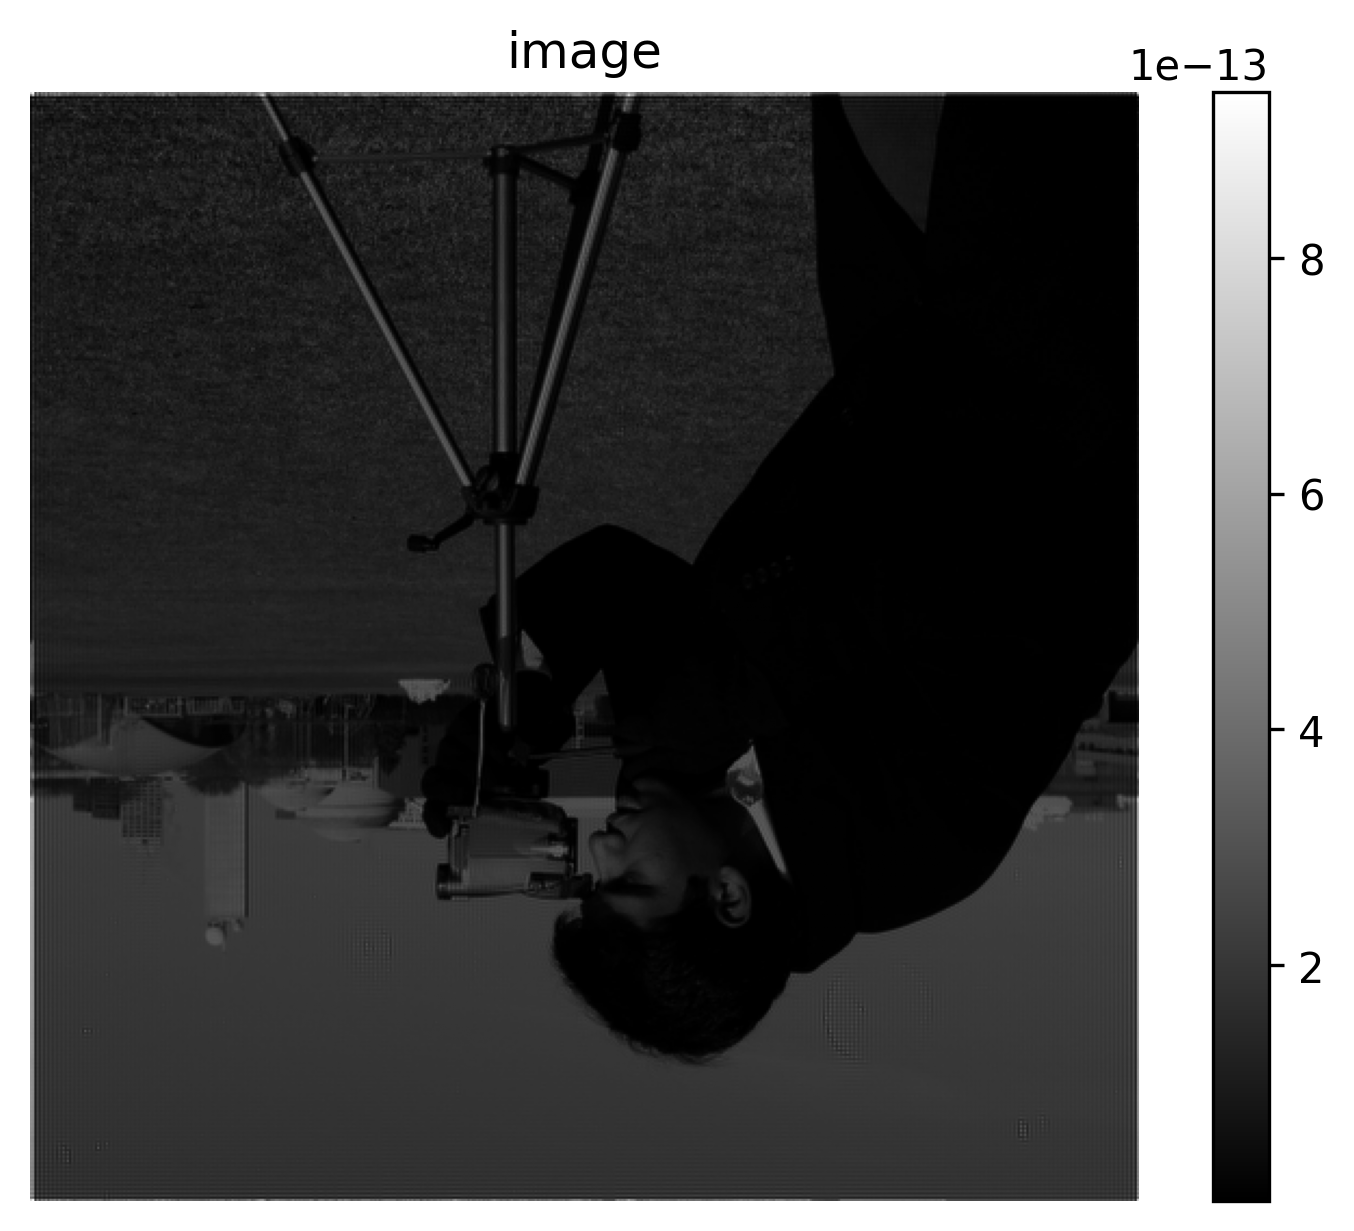

In [8]:
show_image(image[:, :, :, :, :].squeeze())